In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())


Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
import imutils


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 700,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )



In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:



# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/2560by2560_noresize_collate.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [39]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 12
GOAL_HEIGHT = 64

def find_ratio(h, w, goal):
    return goal/h
    

def predict(image_path):
    MAX_RATIO = 12
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

def predict_old(image_path):
    MAX_RATIO = 12
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
    new_h = 128
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    

In [9]:
IMAGES= ['Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png"
         
    

]

(64, 2997, 3)


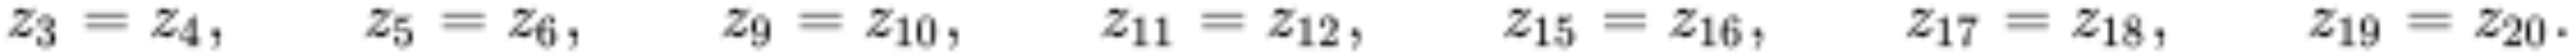

None
torch.Size([1, 64, 2997])

Predicted formula:
 <S> \begin{array} { c c c } { q } & { \frac { q } { q } } \\ { q a b ^ { \mu } } & { q ^ { \mu } } & { q ^ { \mu } a ^ { \mu } } \\ { q a ^ { \mu } } & { q ^ { \mu } a ^ { \mu } } & { } & { q a ^ { \mu } a ^ { \mu } } \\ \end{array} } & { q ^ { \mu } a ^ { \mu } } & { q ^ { \mu } a ^ { \mu } } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 278, 3)


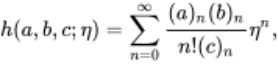

None
torch.Size([1, 64, 278])

Predicted formula:
 <S> R \left( G _ { 1 } \, \partial _ { 2 } \, C _ { 1 } ^ { * } \, T \right) \equiv \, \sum _ { x = 0 } ^ { \infty } \, \frac { ( G ) _ { x } \left( R \right) _ { x } \left( R \right) _ { x } \left( R \right) _ { x } } { T _ { 1 } \left( C \right) _ { x } } { T _ { 1 } \left( C \right) _ { x } } \, \overline { { T } } ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 285, 3)


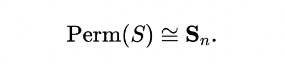

None
torch.Size([1, 64, 285])

Predicted formula:
 <S> \qquad \qquad \qquad \prod { \bf { D } } \mathrm { T r } \mathrm { T r } \left( \bigoplus ^ { \infty } \right) \ \sum _ { r = 1 } \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


<IPython.core.display.Math object>

None
(64, 242, 3)


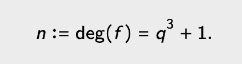

None
torch.Size([1, 64, 242])

Predicted formula:
 <S> \begin{array} { c c c } { B \; : } & { = } & { \mathrm { G C } G \left( f \right) \; \equiv \; G ^ { 2 } \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \;


<IPython.core.display.Math object>

None
(64, 277, 3)


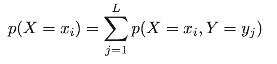

None
torch.Size([1, 64, 277])

Predicted formula:
 <S> { \cal P } ( X \, = \, g _ { \xi } ) = \sum _ { j = 1 } ^ { L } p ( X \, = \, x _ { i j } , Y \, = \, g _ { i j } , Y \, = \, g _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 216, 3)


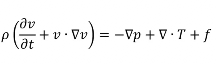

None
torch.Size([1, 64, 216])

Predicted formula:
 <S> \rho \left( \frac { \partial \varphi } { \partial { \cal T } } + v \cdot \nabla _ { \cal T } \right) \simeq - \nabla p + \nabla \cdot T + <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 456, 3)


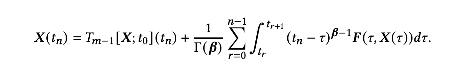

None
torch.Size([1, 64, 456])

Predicted formula:
 <S> X ( t _ { R } ) = T _ { R m - 1 } ^ { n } \{ X , t _ { R } \} ( t _ { R } ) + \frac { 1 } { \Gamma ( p ) } \sum _ { R = 0 } ^ { n - 1 } \int _ { L _ { L } } ^ { L + 1 } ( t _ { R } - \tau ) F - 1 } F ( \tau _ { R } X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 664, 3)


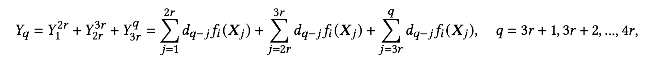

None
torch.Size([1, 64, 664])

Predicted formula:
 <S> Y _ { Q } \simeq Y _ { 1 } ^ { 2 T r } + Y _ { 2 T } ^ { 2 r } + Y _ { Q ^ { \prime } } ^ { 2 r } \equiv \sum _ { j = 1 } ^ { 2 r } d _ { q - j } f _ { l } ^ { \prime } ( X _ { j } ) + \sum _ { j = j _ { j } } ^ { 2 r } d _ { q - j } ^ { \prime } ( X _ { j } ) ) , \quad q \equiv S r + 1 , 2 j _ {


<IPython.core.display.Math object>

None
(64, 562, 3)


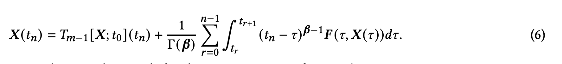

None
torch.Size([1, 64, 562])

Predicted formula:
 <S> X ( t _ { n } ) \approx T _ { m - 1 } \{ X ; t _ { 0 } \} ( t _ { n } ) + \frac { 1 } { \Gamma ( p ) } \sum _ { p = 0 } ^ { t - 1 } \int _ { t _ { p } } ^ { t _ { p } } ( t _ { n } - \tau ) \delta ^ { p - 1 } F ( \tau _ { 1 } X ( \tau ) ) d \tau . \tag { 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 135, 3)


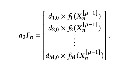

None
torch.Size([1, 64, 135])

Predicted formula:
 <S> s _ { s s } = \left[ \begin{array} { c c c } { 4 \pi \pi s ( 4 , 4 ) } \\ { 2 \pi s } & { 4 \pi ( 4 \pi ) ^ { 2 } + 1 } \\ \end{array} \right] } \\ \end{array} \right] <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 291, 3)


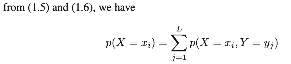

None
torch.Size([1, 64, 291])

Predicted formula:
 <S> \mathrm { f o n e ( 1 , S ) \mathrm { s o d } ( 1 , \mathrm { w o d e n } } } \\ { p ( X - x _ { i } ) - \sum _ { j = 1 } ^ { j } p ( X - x _ { i } ; Y - y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 384, 3)


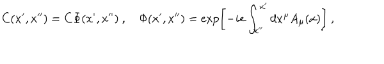

None
torch.Size([1, 64, 384])

Predicted formula:
 <S> \zeta ( v _ { e } ^ { \prime } , \kappa ^ { \prime } ) \approx C ( z ^ { \prime } , \rho ^ { \prime } ) \, , \quad \Theta ( z ^ { \prime } , z ^ { \prime \prime } ) \approx \sigma _ { N } ^ { \infty } d \chi ^ { \prime \prime } A _ { \mu } ( x ) \right) \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [40]:
for image in IMAGES:
    predict(image)